# Localizer

In [32]:
import os
import cv2
import math
import time
import numpy as np
import matplotlib.pyplot as plt

In [33]:
# Enable multithreading
cv2.setUseOptimized(True)
cv2.setNumThreads(4)

### Helper functions

In [34]:
def plot_images(list_of_images, max_col=4):
    """
    @brief Plot a list of given images with
    @param list_of_images List of images to plot
    @param max_col Number of colomns to plot your figures
    """
    n = len(list_of_images)
    if n == 1:
        plt.imshow(list_of_images[0]); plt.axis('off'); plt.show()
    else:
        # Get number of columns and rows required
        r, c = 1, n
        if n > max_col:
            c = max_col
            r = int(math.ceil(n/max_col))
    
        fig = plt.figure(figsize=(17, max_col * r))
        for i, (img) in enumerate(list_of_images):
            ax = fig.add_subplot(r, c, (i+1))
            ax.set_title("Image " + str(i))
            ax.axis('off')
            ax.imshow(img, cmap=plt.cm.gray)

In [127]:
def pad_resize_images(img_list, output_size):
    """
    @brief Resize each image within a list to a given shape while also keeping its aspect ratio by the use of padding
    @param img_list The list of images to resize
    @param output_size The shape of the output images are output_size x output_size
    """
    BLACK = 0
    result = np.empty_like(img_list)
    
    for i, img in enumerate(img_list):
        height, width = img.shape
        ratio = float(output_size) / max([height, width]) 
        height_new, width_new = tuple([max(int(val * ratio), 1) for val in (height, width)])
        img_resized = cv2.resize(img, (height_new, width_new))

        height_adjust = output_size - height_new
        width_adjust = output_size - width_new
        
        top = math.ceil(height_adjust / 2)
        bot = height_adjust - top
        left = math.ceil(width_adjust / 2)
        right = width_adjust - left
        
        result[i] = cv2.resize(
            cv2.copyMakeBorder(img_resized, top, bot, left, right, cv2.BORDER_CONSTANT, value=BLACK),
            (output_size, output_size))
    return result

In [36]:
classes = ['articulated_truck', 'bicycle', 'bus', 'car', 'motorcycle',
           'motorized_vehicle', 'non-motorized_vehicle', 'pedestrian',
           'pickup_truck', 'single_unit_truck', 'work_van']

### Data preparation

In [55]:
path_localization = './MIO-TCD-Localization'
path_localization_test = os.path.join(path_localization, 'test')
path_localization_train = os.path.join(path_localization, 'train')

num_images = 1000
# Read training images
train_images = np.array([cv2.imread(os.path.join(path_localization_train, img)) for img in os.listdir(path_localization_train)[:num_images]])

# Read testing images
test_images = np.array([cv2.imread(os.path.join(path_localization_test, img)) for img in os.listdir(path_localization_test)[:num_images]])

print(train_images.shape)
print(test_images.shape)

(1000,)
(1000,)


In [56]:
# Grayscale, resize and flatten images
train_images_gray = np.array([cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in train_images])
test_images_gray = np.array([cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in test_images])

img_size = 128
train_images_res = np.array([x.flatten() for x in pad_resize_images(train_images_gray, img_size)])
test_images_res = np.array([x.flatten() for x in pad_resize_images(test_images_gray, img_size)])

print(train_images_res.shape)
print(test_images_res.shape)

(1000, 16384)
(1000, 16384)


### Region Proposal (Selective Search)

Number of region proposals: 8777


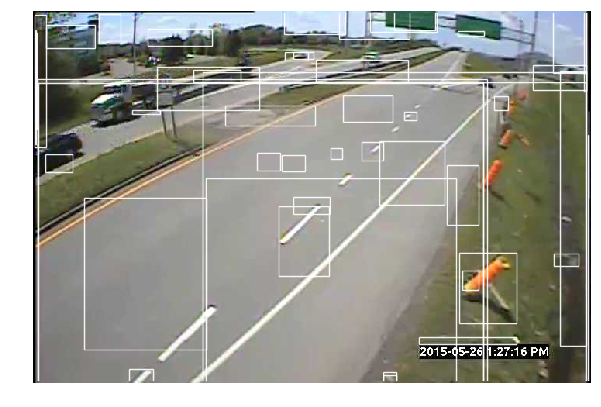

Number of region proposals: 9542


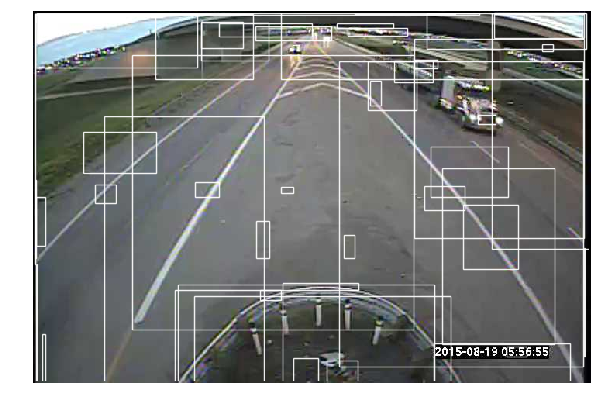

Number of region proposals: 3479


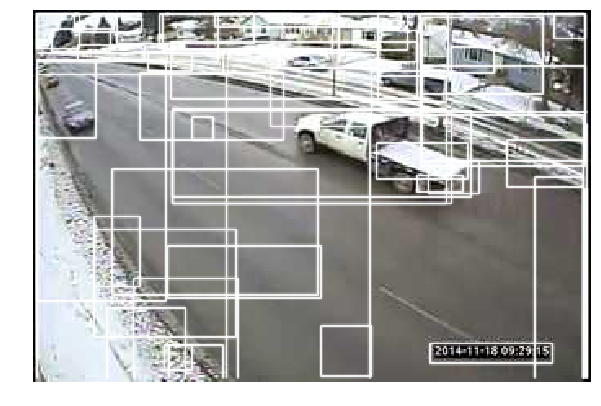

Number of region proposals: 8993


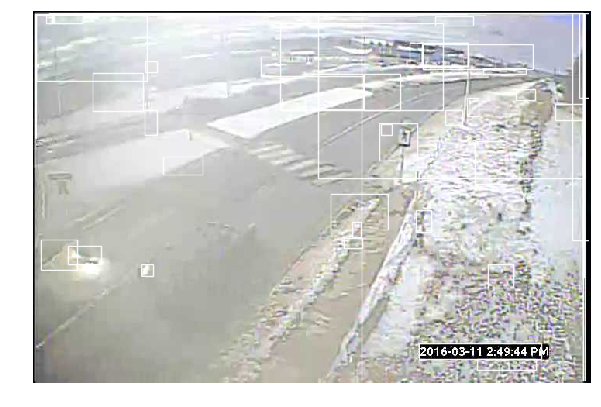

Number of region proposals: 15907


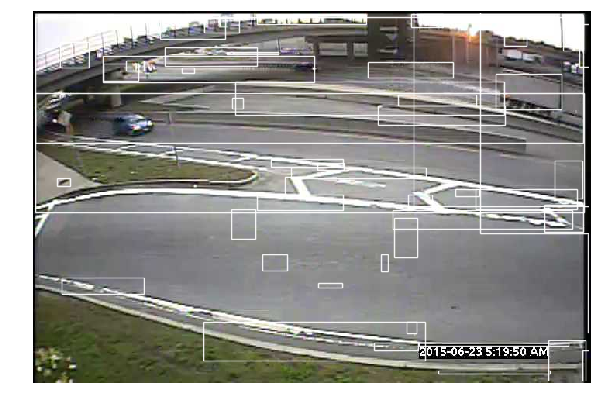

In [116]:
fast = False
select_sch = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
pois = []

for img in train_images[:5]:
    select_sch.setBaseImage(img)
    if fast:
        select_sch.switchToSelectiveSearchFast()
    else:
        select_sch.switchToSelectiveSearchQuality()
    regions = select_sch.process()
    pois += [img[y:y+h, x:x+w, :] for x, y, w, h in regions[:100]]
    print(f'Number of region proposals: {len(regions)}')
    
    img_cpy = img.copy()
    for reg in regions[:50]:
        x, y, w, h = reg
        cv2.rectangle(img_cpy, (x,y), (x+w,y+h), (255,255,255), 1, cv2.LINE_AA)
    plt.figure(figsize=(10,10))
    plt.imshow(cv2.cvtColor(img_cpy, cv2.COLOR_BGR2RGB)), plt.axis('off')
    plt.show()

In [128]:
# Grayscale, resize and pad points of interest images
pois_gray = np.array([cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in pois])
pois_res = np.array([x.flatten() for x in pad_resize_images(pois_gray, img_size)])